In [1]:
import tensorflow as tf 
print(tf.__version__)

2023-11-10 07:51:12.016066: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-10 07:51:12.760019: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-10 07:51:12.760071: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-10 07:51:12.762731: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-10 07:51:13.105607: I tensorflow/core/platform/cpu_feature_g

2.14.0


In [3]:
!git clone https://github.com/sartajbhuvaji/brain-tumor-classification-dataset


Cloning into 'brain-tumor-classification-dataset'...
remote: Enumerating objects: 3039, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 3039 (delta 0), reused 0 (delta 0), pack-reused 3035
Receiving objects: 100% (3039/3039), 79.25 MiB | 1.25 MiB/s, done.
Updating files: 100% (3264/3264), done.


In [4]:
!ls

brain-tumor-classification-dataset  main.ipynb


In [5]:
!mv brain-tumor-classification-dataset dataset

In [10]:
import os 

for dirpath, dirnames, filenames in os.walk("dataset"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'dataset'.
There are 4 directories and 0 images in 'dataset/Testing'.
There are 0 directories and 74 images in 'dataset/Testing/pituitary_tumor'.
There are 0 directories and 115 images in 'dataset/Testing/meningioma_tumor'.
There are 0 directories and 105 images in 'dataset/Testing/no_tumor'.
There are 0 directories and 100 images in 'dataset/Testing/glioma_tumor'.
There are 4 directories and 0 images in 'dataset/Training'.
There are 0 directories and 827 images in 'dataset/Training/pituitary_tumor'.
There are 0 directories and 822 images in 'dataset/Training/meningioma_tumor'.
There are 0 directories and 395 images in 'dataset/Training/no_tumor'.
There are 0 directories and 826 images in 'dataset/Training/glioma_tumor'.


In [11]:
#getting the classnames 
import pathlib
import numpy as np
data_dir = pathlib.Path("dataset/Training//")
class_names = np.array(sorted(item.name for item in data_dir.glob("*")))
print(class_names)

['glioma_tumor' 'meningioma_tumor' 'no_tumor' 'pituitary_tumor']


In [12]:
train_dir = "dataset/Training/"
test_dir = "dataset/Testing/"

In [13]:
# visualing an random image from any class

import matplotlib.pyplot as plt 
import matplotlib.image as mpimg 
import random 

def view_random_image(target_dir, target_class):

    target_folder = target_dir + target_class
    random_image = random.sample(os.listdir(target_folder), 1)

    img = mpimg.imread(target_folder+"/"+random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off")

    print(f"Image shape : {img.shape}")
    return img 


Image shape : (295, 236, 3)


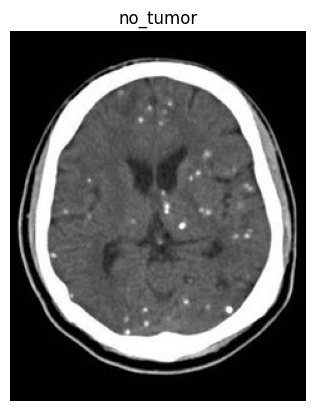

In [14]:
img = view_random_image(test_dir, random.choice(class_names))

## Preprocessing the images

In [15]:
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [16]:
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32,
                                               target_size=(224,224),
                                               class_mode="categorical")

test_data = test_datagen.flow_from_directory(test_dir,
                                               batch_size=32,
                                               target_size=(224,224),
                                               class_mode="categorical")

Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


## Creating a EfficientNetB0 model

In [39]:
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [40]:
import tensorflow_hub as hub

In [41]:
def create_model(model_url,num_classes):

    feature_extractor_layer = hub.KerasLayer(model_url,
                                             trainable=False,
                                             input_shape=(224,224,3))

    model = tf.keras.Sequential([
        feature_extractor_layer,
        tf.keras.layers.Dense(num_classes,activation="softmax",name="output_layer")
    ])
    return model 

In [42]:
efficientnet_model = create_model(efficientnet_url,4)

In [43]:
efficientnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [44]:
efficientnet_history = efficientnet_model.fit(train_data,epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data))

Epoch 1/5
90/90 [==============================] - 64s 498ms/step - loss: 0.8444 - accuracy: 0.6707 - val_loss: 1.0610 - val_accuracy: 0.5736
Epoch 2/5
90/90 [==============================] - 34s 375ms/step - loss: 0.5054 - accuracy: 0.8296 - val_loss: 1.0556 - val_accuracy: 0.5914
Epoch 3/5
90/90 [==============================] - 34s 376ms/step - loss: 0.4223 - accuracy: 0.8547 - val_loss: 1.0960 - val_accuracy: 0.6193
Epoch 4/5
90/90 [==============================] - 35s 384ms/step - loss: 0.3764 - accuracy: 0.8672 - val_loss: 1.0674 - val_accuracy: 0.6193
Epoch 5/5
90/90 [==============================] - 35s 380ms/step - loss: 0.3437 - accuracy: 0.8791 - val_loss: 1.0909 - val_accuracy: 0.6269


In [ ]:
efficientnet_model.save("efficientnetb0-62.69-valaccuracy.keras")

In [15]:
efficientnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              4049564   
                                                                 
 output_layer (Dense)        (None, 4)                 5124      
                                                                 
Total params: 4054688 (15.47 MB)
Trainable params: 5124 (20.02 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [17]:
#function to display loss curve 
import matplotlib.pyplot as plt 
import numpy as np

def plot_loss_curve(history):
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs = range(len(history.history["loss"]))

    plt.figure(figsize=(14,6))
    plt.subplot(1,2,1)
    plt.plot(epochs,accuracy,label="training accuracy")
    plt.plot(epochs,val_accuracy,label="validation accuracy")
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs,loss,label="training loss")
    plt.plot(epochs,val_loss,label="validation loss")
    plt.title("loss")
    plt.xlabel("epochs")
    plt.legend()


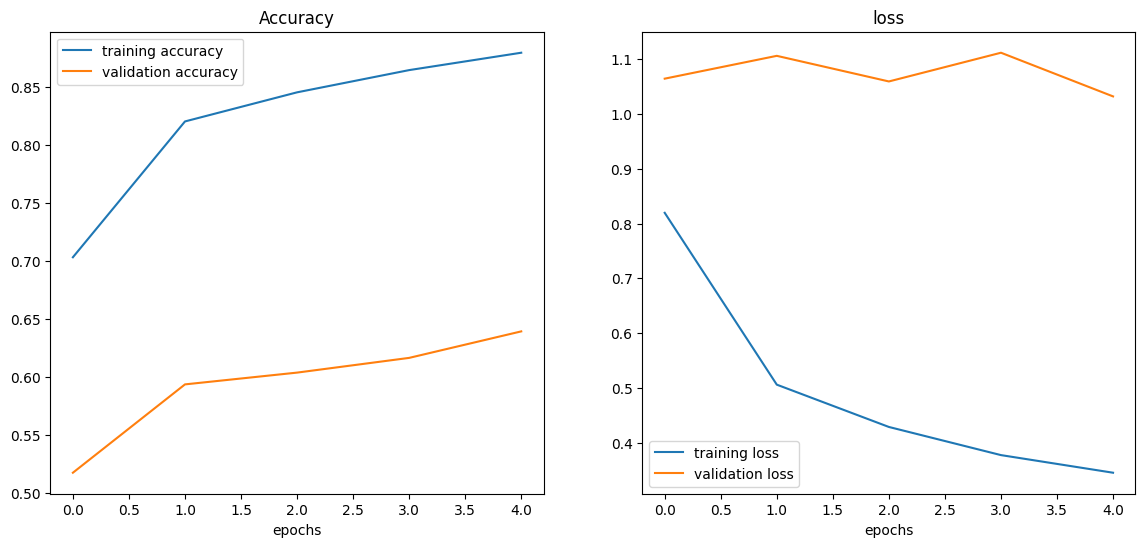

In [17]:
plot_loss_curve(efficientnet_history)

## Evaluating the 1st model

In [18]:
efficientnet_model.evaluate(test_data)

13/13 [==============================] - 5s 366ms/step - loss: 1.0323 - accuracy: 0.6396


[1.032304286956787, 0.6395938992500305]

## Trying data augmentation 

In [33]:
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=0.2,
                                             zoom_range=0.2,
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             horizontal_flip=True)

train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                batch_size=32,
                                                                target_size=(224,224),
                                                                class_mode="categorical",
                                                                shuffle=True)

Found 2870 images belonging to 4 classes.


In [16]:
efficientnet_model_2 = create_model(efficientnet_url,4)

efficientnet_model_2.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

efficientnet_history_2 = efficientnet_model_2.fit(train_data_augmented,epochs=5,
                                  steps_per_epoch=len(train_data_augmented),
                                  validation_data=test_data,
                                  validation_steps=len(test_data))


Epoch 1/5


2023-11-10 00:13:16.959185: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-10 00:13:17.986454: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-10 00:13:19.223671: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-10 00:13:24.723817: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f95f001c1c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-10 00:13:24.723882: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce MX230, Compute Capability 6.1
2023-11-10 00:13:24.747776: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


 1/90 [..............................] - ETA: 24:46 - loss: 1.5954 - accuracy: 0.2188

2023-11-10 00:13:24.966596: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


90/90 [==============================] - 60s 485ms/step - loss: 0.8930 - accuracy: 0.6564 - val_loss: 1.1865 - val_accuracy: 0.5152
Epoch 2/5
90/90 [==============================] - 38s 418ms/step - loss: 0.5692 - accuracy: 0.7969 - val_loss: 1.2170 - val_accuracy: 0.5482
Epoch 3/5
90/90 [==============================] - 40s 438ms/step - loss: 0.5055 - accuracy: 0.8174 - val_loss: 1.1797 - val_accuracy: 0.6015
Epoch 4/5
90/90 [==============================] - 43s 467ms/step - loss: 0.4685 - accuracy: 0.8355 - val_loss: 1.1278 - val_accuracy: 0.5863
Epoch 5/5
90/90 [==============================] - 48s 524ms/step - loss: 0.4313 - accuracy: 0.8411 - val_loss: 1.1594 - val_accuracy: 0.5914


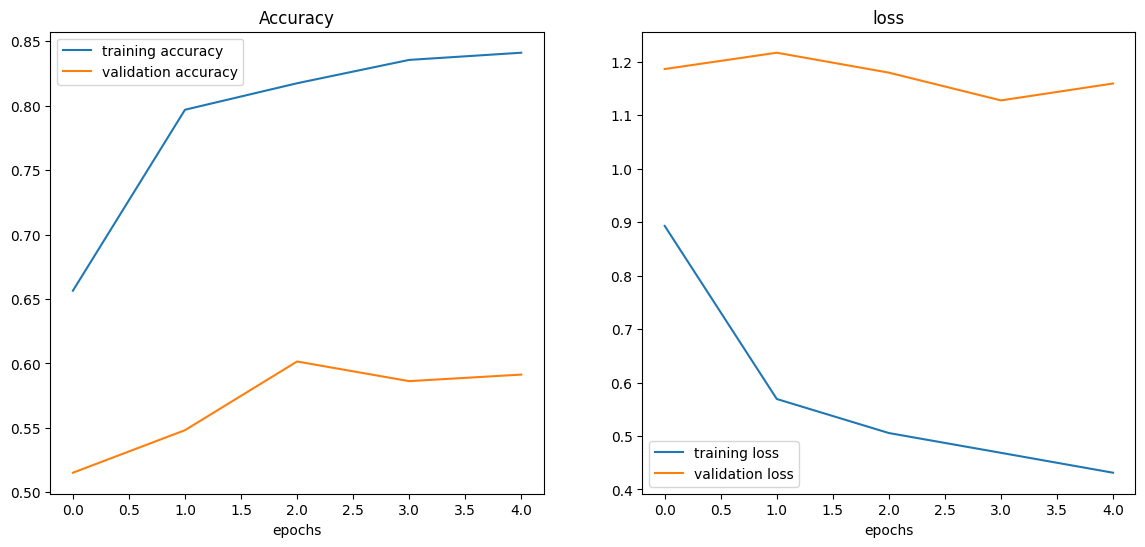

In [17]:
plot_loss_curve(efficientnet_history_2)


## Evaludating the 2nd model

In [28]:
efficientnet_model_2.evaluate(test_data)

13/13 [==============================] - 6s 380ms/step - loss: 1.1594 - accuracy: 0.5914


[1.1593666076660156, 0.5913705825805664]

## Prediction with custom images

In [18]:
# preparing the image fo model 
def prep_image(filename, img_shape=224):
    img = tf.io.read_file(filename)

    img = tf.io.decode_image(img, channels=3)
    
    img = tf.image.resize(img, size = [img_shape, img_shape])

    img = img/255.
    
    img = tf.expand_dims(img,axis=0)

    return img

In [19]:
def pred_and_plot(model, filename, class_names):
    img = prep_image(filename)
    
    pred = model.predict(img)

   
    predicted_class_index = tf.argmax(pred, axis=1)[0].numpy()
    pred_class = class_names[predicted_class_index]
    
    img = tf.squeeze(img,axis = 0)
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False)

1/1 [==============================] - 0s 105ms/step


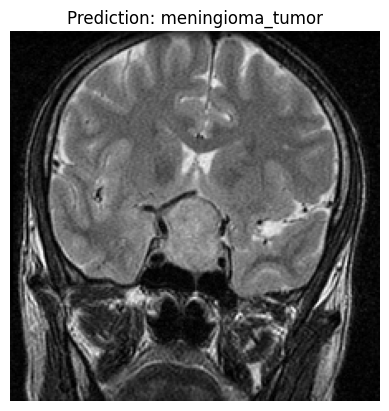

In [27]:
pred_and_plot(efficientnet_model_2,"./pituatory-tumor-test.jpg",class_names)

1/1 [==============================] - 6s 6s/step


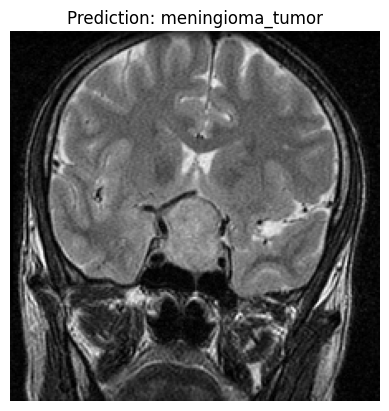

In [22]:
pred_and_plot(efficientnet_model,"./pituatory-tumor-test.jpg",class_names)

1/1 [==============================] - 0s 89ms/step


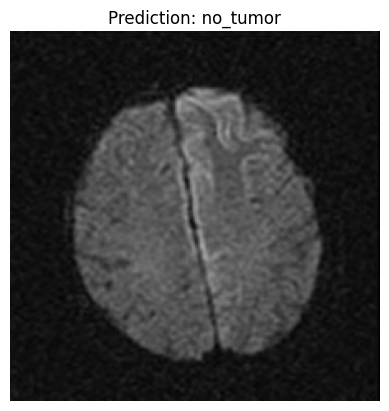

In [23]:
pred_and_plot(efficientnet_model,"./no-tumour-test.jpg",class_names)

1/1 [==============================] - 0s 55ms/step


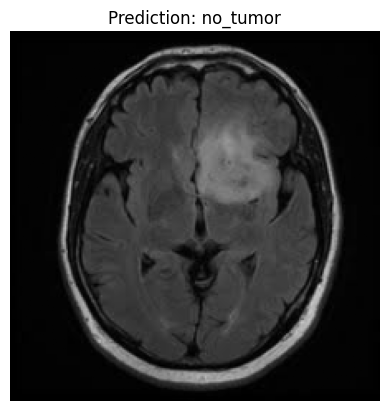

In [24]:
pred_and_plot(efficientnet_model,"./glioma-tumor-test.jpg",class_names)

1/1 [==============================] - 0s 61ms/step


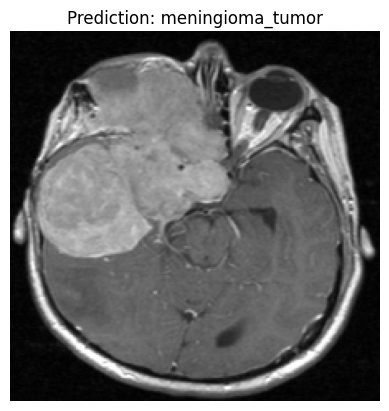

In [25]:
pred_and_plot(efficientnet_model,"./meningioma-tumor-test.jpg",class_names) 

## Creating a VGG19 Model

In [3]:
import tensorflow as tf 
from tensorflow.keras.applications.vgg19 import VGG19

In [8]:
vgg = VGG19(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

for layer in vgg.layers:
    layer.trainable = False

x = tf.keras.layers.Flatten()(vgg.output)
prediction = tf.keras.layers.Dense(4, activation='softmax')(x)

vgg_model = tf.keras.models.Model(inputs=vgg.input, outputs=prediction)

vgg_model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [20]:
vgg_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 


vgg_history = vgg_model.fit(train_data,epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data))

Epoch 1/5


2023-11-10 10:58:16.884766: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-10 10:58:19.206003: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-10 10:58:20.494324: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 939.37MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-11-10 10:58:20.830624: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-11-10 10:58:20.836913: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to alloca

90/90 [==============================] - 165s 1s/step - loss: 0.8511 - accuracy: 0.7003 - val_loss: 1.6633 - val_accuracy: 0.6015
Epoch 2/5
90/90 [==============================] - 104s 1s/step - loss: 0.3205 - accuracy: 0.8805 - val_loss: 1.8056 - val_accuracy: 0.6624
Epoch 3/5
90/90 [==============================] - 106s 1s/step - loss: 0.2979 - accuracy: 0.8854 - val_loss: 1.8149 - val_accuracy: 0.6853
Epoch 4/5
90/90 [==============================] - 108s 1s/step - loss: 0.2177 - accuracy: 0.9216 - val_loss: 1.9651 - val_accuracy: 0.6904
Epoch 5/5
90/90 [==============================] - 108s 1s/step - loss: 0.1356 - accuracy: 0.9592 - val_loss: 2.0579 - val_accuracy: 0.7056


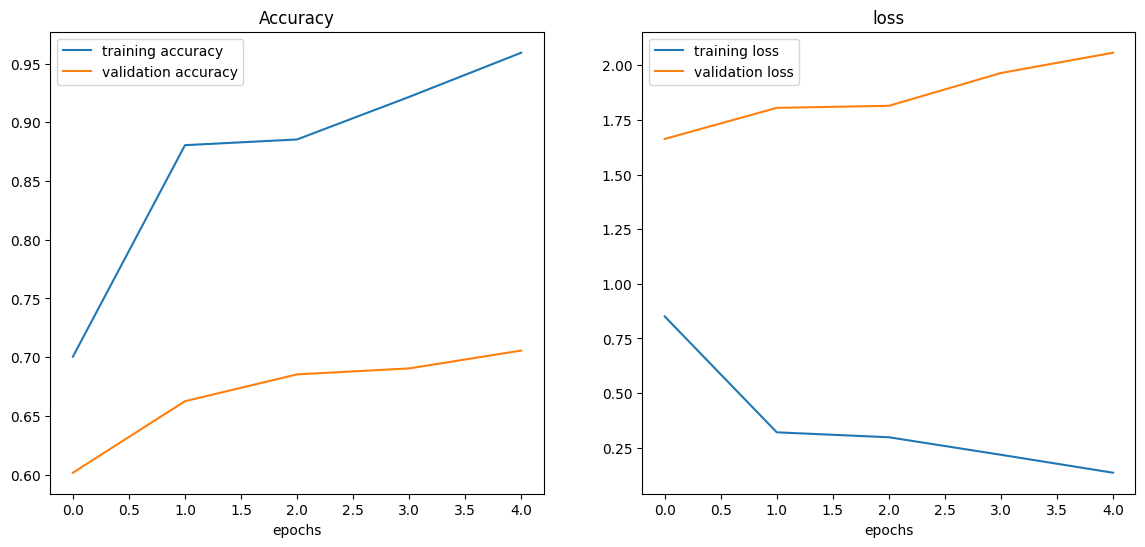

In [21]:
plot_loss_curve(vgg_history)

1/1 [==============================] - 0s 32ms/step


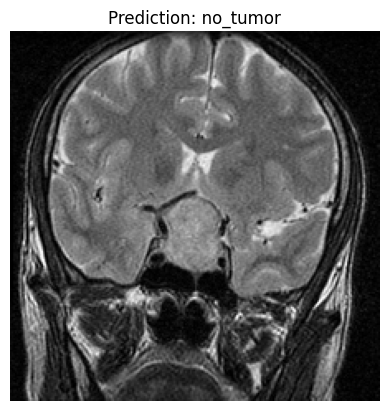

In [26]:
pred_and_plot(vgg_model,"./pituatory-tumor-test.jpg",class_names)

1/1 [==============================] - 0s 32ms/step


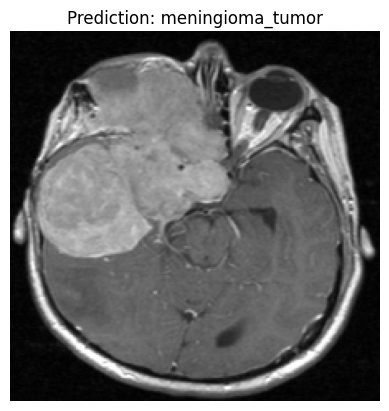

In [27]:
pred_and_plot(vgg_model,"./meningioma-tumor-test.jpg",class_names)

In [36]:
vgg_model.evaluate(test_data)

13/13 [==============================] - 13s 915ms/step - loss: 2.0579 - accuracy: 0.7056


[2.0579400062561035, 0.7055837512016296]

In [30]:
vgg_model.save("vgg-70.56-valaccuracy.keras")